# Recurrent Neural Networks
### Recurrent Neural Networks (RNNs) is a supervised learning algorithm designed to process sequential data by maintaining a hidden state that captures temporal dependencies, making it ideal for tasks like sentiment analysis of movie reviews. It excels in classifying text sequences (e.g., determining positive or negative sentiment based on word order in IMDB reviews) and can handle time-series or sequential data, requiring iterative training to update the hidden state across timesteps. The algorithm assumes that the sequence has meaningful temporal or contextual relationships, which enables effective pattern learning but may not hold for datasets with independent or noisy sequences. Its strength lies in its ability to model long-term dependencies in sequential data, but it can be computationally intensive, prone to vanishing gradient problems without advanced variants, and sensitive to hyperparameter choices (e.g., sequence length, learning rate).

### Use RNNs for sequence-based prototypes, with tuning and optimization to enhance performance, particularly for deployment in natural language processing or time-series prediction systems.

| Aspect | Details |
| :- | :- |
| Use For           | Sequence classification (e.g., sentiment analysis, speech recognition)<br>Can be extended to time-series prediction or machine translation |
| Key Assumptions   | - Temporal or contextual dependencies in the sequence<br>- Independent observations<br>- Sufficient data for state updates |
| Advantages        | - Captures sequential dependencies<br>- Effective for variable-length inputs<br>- Flexible with recurrent architectures |
| Disadvantages     | - Computationally intensive during training<br>- Prone to vanishing gradient issues<br>- Sensitive to hyperparameter tuning |
| Avoid When        | - Datasets with independent or noisy sequences<br>- Very small datasets with limited samples<br>- Real-time applications with low latency |
| Real-World Use Case | Sentiment analysis (e.g., classifying IMDB reviews as positive or negative)<br>Time-series prediction (e.g., forecasting stock prices) |

## Problem Description: 
### Classify movie reviews from the IMDB dataset as positive or negative sentiment based on the sequence of words. This is a binary classification problem where RNNs excel at modeling temporal dependencies in text data.

Using dataset https://www.tensorflow.org/datasets/catalog/imdb_reviews

In [99]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout, Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.datasets import imdb
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os

In [100]:
def setup_gpu():
    ## tf version
    print("TensorFlow version:", tf.__version__)

    #### GPU Optimisation code ####
    print("GPUs:",tf.config.list_physical_devices('GPU'))

    print("GPUs: Allocate GPU Memory and create a new session")

    # Get the GPU memory fraction to allocate
    gpu_memory_fraction = 0.5

    # Create GPUOptions with the fraction of GPU memory to allocate
    gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=gpu_memory_fraction)

    # Create a session with the GPUOptions
    session = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(gpu_options=gpu_options))

In [101]:
setup_gpu()

TensorFlow version: 2.19.0
GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPUs: Allocate GPU Memory and create a new session


I0000 00:00:1749840725.526455 1412869 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5119 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:01:00.0, compute capability: 8.6


In [102]:
project_dir = './15_rnn_recurrent_neural_network'

# load the IMDB dataset
num_words = 10000  # limit vocabulary to 10,000 most frequent words
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=num_words)
print("Training set shape:", len(X_train), "Test set shape:", len(X_test))

Training set shape: 25000 Test set shape: 25000


In [103]:
# preprocess the data (pad sequences to a fixed length)
max_length = 200  # maximum length of sequences
X_train = pad_sequences(X_train, maxlen=max_length)
X_test = pad_sequences(X_test, maxlen=max_length)
print("Padded Train set shape:", X_train.shape, "Padded Test set shape:", X_test.shape)

Padded Train set shape: (25000, 200) Padded Test set shape: (25000, 200)


In [104]:
# split training data for validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
print("Train set shape:", X_train.shape, "Validation set shape:", X_val.shape, "Test set shape:", X_test.shape)

Train set shape: (20000, 200) Validation set shape: (5000, 200) Test set shape: (25000, 200)


In [105]:
# build the RNN model
rnn_model = Sequential([
    Embedding(num_words, 32, input_length=max_length),  # Embedding layer
    SimpleRNN(64, return_sequences=True),  # RNN layer (return full sequence)
    Dropout(0.6),  # Add dropout to prevent overfitting
    SimpleRNN(32, return_sequences=False),  # RNN layer (return last output)
    Dropout(0.6),  # Add dropout to prevent overfitting
    Dense(32, activation='relu'),
    Dropout(0.6),  # Add dropout
    Dense(16, activation='relu'),
    Dropout(0.6),  # Add dropout
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# compile the model with a custom learning rate
custom_optimizer = Adam(learning_rate=0.01)
rnn_model.compile(optimizer=custom_optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# define callbacks for early stopping and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=0.1)

# train the CNN model
history = rnn_model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_val, y_val), 
                       callbacks=[early_stopping, reduce_lr], verbose=1)

Epoch 1/50


/home/tarun/miniconda3/envs/own-ml-dl-experiments/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


313/313 ━━━━━━━━━━━━━━━━━━━━ 20s 53ms/step - accuracy: 0.5022 - loss: 0.7413 - val_accuracy: 0.4874 - val_loss: 0.6941 - learning_rate: 0.0100
Epoch 2/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.5001 - loss: 0.6939 - val_accuracy: 0.5126 - val_loss: 0.6931 - learning_rate: 0.0100
Epoch 3/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.4995 - loss: 0.6938 - val_accuracy: 0.4874 - val_loss: 0.6933 - learning_rate: 0.0100
Epoch 4/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 14s 46ms/step - accuracy: 0.5040 - loss: 0.6934 - val_accuracy: 0.4874 - val_loss: 0.6948 - learning_rate: 0.0100
Epoch 5/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 15s 47ms/step - accuracy: 0.4991 - loss: 0.6936 - val_accuracy: 0.5126 - val_loss: 0.6928 - learning_rate: 0.0100
Epoch 6/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 15s 47ms/step - accuracy: 0.4958 - loss: 0.6935 - val_accuracy: 0.5126 - val_loss: 0.6931 - learning_rate: 0.0100
Epoch 7/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 15s 47ms/step - accuracy: 0.4956 - loss: 0.6934

In [106]:
# predict and evaluate
y_pred = rnn_model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int).flatten()
accuracy = accuracy_score(y_test, y_pred_classes)
conf_matrix = confusion_matrix(y_test, y_pred_classes)
class_report = classification_report(y_test, y_pred_classes, output_dict=True)

print(f'Accuracy: {accuracy:.2f}')
print('Confusion Matrix:')
print(conf_matrix)
print('Classification Report:')
print(classification_report(y_test, y_pred_classes, target_names=['Negative', 'Positive']))

782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step
Accuracy: 0.50
Confusion Matrix:
[[    0 12500]
 [    0 12500]]
Classification Report:
              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00     12500
    Positive       0.50      1.00      0.67     12500

    accuracy                           0.50     25000
   macro avg       0.25      0.50      0.33     25000
weighted avg       0.25      0.50      0.33     25000



/home/tarun/miniconda3/envs/own-ml-dl-experiments/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/tarun/miniconda3/envs/own-ml-dl-experiments/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/tarun/miniconda3/envs/own-ml-dl-experiments/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavio

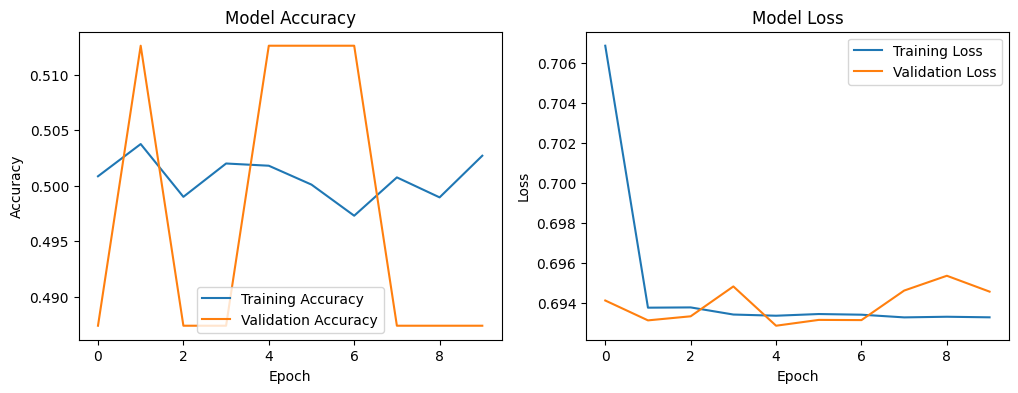

In [107]:
# visualize training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

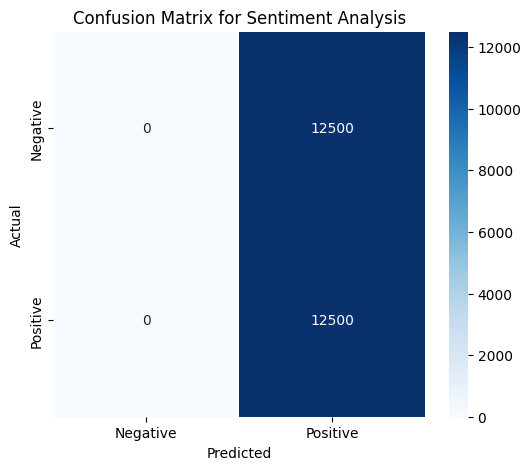

In [108]:
# visualize confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Sentiment Analysis')
plt.show()

In [109]:
# save the model in a 'model' subdirectory
model_dir = project_dir + '/model'
os.makedirs(model_dir, exist_ok=True)
model_filename = os.path.join(model_dir, 'imdb_rnn_model.h5')
rnn_model.save(model_filename)
print(f'Model saved as {model_filename}')

Model saved as ./15_rnn_recurrent_neural_network/model/imdb_rnn_model.h5


In [110]:
# load the PCA model 
loaded_model = tf.keras.models.load_model(model_filename)
sample_image = X_test[0:1]  # First test image
sample_prediction = loaded_model.predict(sample_image)
sample_prediction_class = np.argmax(sample_prediction, axis=1)
print(f'Predicted class for sample image: {sample_prediction_class[0]} {["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"][sample_prediction_class[0]]})')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step
Predicted class for sample image: 0 airplane)
